## Anomaly Detection - Project
### Authors: Norbert Klockiewicz, Kacper Majchrzak, Patryk Kożuch

#### Based on: <a href="https://arxiv.org/pdf/1802.04431.pdf">Detecting Spacecraft Anomalies Using LSTMs and Nonparametric Dynamic Thresholding</a>

Imports

In [80]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import more_itertools as mit
from keras.models import Sequential
from keras.callbacks import History, EarlyStopping
from keras.layers import Dense, Activation, Dropout, LSTM

In [81]:
CHANNEL = "A-4"

### Class channel - load and prepare data to train model

In [82]:
class Channel:
    def __init__(self, chan_id):
        self.id = chan_id
        self.train = None
        self.test = None
        self.l_s = 250
        self.n_predictions = 10
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.y_hat = None

    def shape_data(self, arr, training=True):
        data = []
        for i in range(len(arr) - self.l_s - self.n_predictions):
            data.append(arr[i: i + self.l_s + self.n_predictions])
            
        data = np.array(data)

        if training:
            np.random.shuffle(data)
            self.X_train = data[:, :-self.n_predictions, :]
            self.y_train = data[:, -self.n_predictions:, 0]
        else:
            self.X_test = data[:, :-self.n_predictions, :]
            self.y_test = data[:, -self.n_predictions:, 0]

    def load_data(self):
        try:
            self.train = np.load(os.path.join("data", "train", "{}.npy".format(self.id)))
            self.test = np.load(os.path.join("data", "test", "{}.npy".format(self.id)))
        except FileNotFoundError as e:
            print(e)

        self.shape_data(self.train)
        self.shape_data(self.test, training=False)

In [83]:
new_channel = Channel(CHANNEL)
new_channel.load_data()

### Class Model - create and train recurrent neural network

In [84]:
class Model:
    def __init__(self, channel):
        self.chan_id = channel.id
        self.y_hat = np.array([])
        self.model = None
        self.train_new(channel)
        

    def train_new(self, channel):
        cbs = [History(), EarlyStopping(monitor='val_loss',
                                        patience=10,
                                        min_delta=0.0003,
                                        verbose=0)]

        self.model = Sequential()

        self.model.add(LSTM(
            80,
            input_shape=(None, channel.X_train.shape[2]),
            return_sequences=True))
        self.model.add(Dropout(0.3))

        self.model.add(LSTM(
            80,
            return_sequences=False))
        self.model.add(Dropout(0.3))

        self.model.add(Dense(
            channel.n_predictions))
        self.model.add(Activation('linear'))

        self.model.compile(loss='mse',
                           optimizer='adam')

        self.model.fit(channel.X_train,
                       channel.y_train,
                       batch_size=64,
                       epochs=35,
                       validation_split=0.2,
                       callbacks=cbs,
                       verbose=True)
        
    def aggregate_predictions(self, y_hat_batch, method='first'):
        agg_y_hat_batch = np.array([])

        for t in range(len(y_hat_batch)):

            start_idx = t - 10
            start_idx = start_idx if start_idx >= 0 else 0

            # predictions pertaining to a specific timestep lie along diagonal
            y_hat_t = np.flipud(y_hat_batch[start_idx:t+1]).diagonal()

            if method == 'first':
                agg_y_hat_batch = np.append(agg_y_hat_batch, [y_hat_t[0]])
            elif method == 'mean':
                agg_y_hat_batch = np.append(agg_y_hat_batch, np.mean(y_hat_t))

        agg_y_hat_batch = agg_y_hat_batch.reshape(len(agg_y_hat_batch), 1)
        self.y_hat = np.append(self.y_hat, agg_y_hat_batch)
              
    def batch_predict(self, channel):
        num_batches = int((channel.y_test.shape[0] - 250)
                          / 70)

        for i in range(0, num_batches + 1):
            prior_idx = i * 70
            idx = (i + 1) * 70

            if i + 1 == num_batches + 1:
                idx = channel.y_test.shape[0]

            X_test_batch = channel.X_test[prior_idx:idx]
            y_hat_batch = self.model.predict(X_test_batch)
            self.aggregate_predictions(y_hat_batch)

        self.y_hat = np.reshape(self.y_hat, (self.y_hat.size,))

        channel.y_hat = self.y_hat

        return channel


In [85]:
model = Model(new_channel)

2024-03-25 18:53:54.452460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-25 18:53:54.453848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-25 18:53:54.454673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/35


2024-03-25 18:53:54.757094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-25 18:53:54.758440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-25 18:53:54.759242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

30/31 [============================>.] - ETA: 0s - loss: 0.0759

2024-03-25 18:53:56.982846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-25 18:53:56.984239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-25 18:53:56.985013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - 3s 39ms/step - loss: 0.0753 - val_loss: 0.0325
Epoch 2/35
31/31 [==============================] - 1s 23ms/step - loss: 0.0319 - val_loss: 0.0270
Epoch 3/35
31/31 [==============================] - 1s 25ms/step - loss: 0.0288 - val_loss: 0.0273
Epoch 4/35
31/31 [==============================] - 1s 22ms/step - loss: 0.0289 - val_loss: 0.0264
Epoch 5/35
31/31 [==============================] - 1s 23ms/step - loss: 0.0291 - val_loss: 0.0260
Epoch 6/35
31/31 [==============================] - 1s 22ms/step - loss: 0.0274 - val_loss: 0.0272
Epoch 7/35
31/31 [==============================] - 1s 24ms/step - loss: 0.0273 - val_loss: 0.0261
Epoch 8/35
31/31 [==============================] - 1s 24ms/step - loss: 0.0264 - val_loss: 0.0265
Epoch 9/35
31/31 [==============================] - 1s 24ms/step - loss: 0.0262 - val_loss: 0.0259
Epoch 10/35
31/31 [==============================] - 1s 23ms/step - loss: 0.0261 - val_loss: 0.0253
Epoch 11/35
31/31 [=

In [86]:
model.batch_predict(new_channel)

1/3 [=========>....................] - ETA: 0s

2024-03-25 18:54:21.566314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-25 18:54:21.567867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-25 18:54:21.568844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 0s 16ms/step


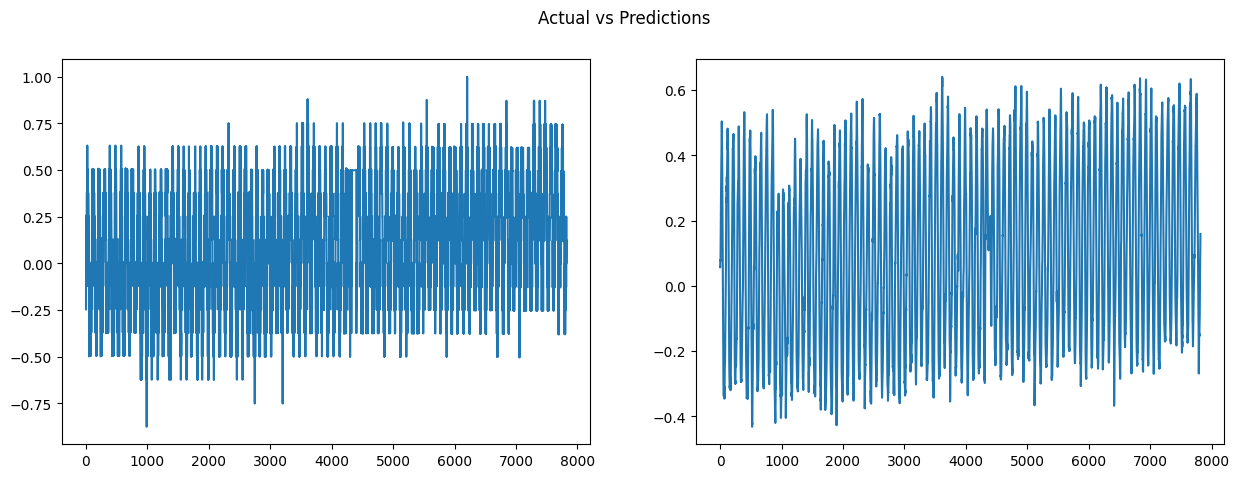

In [87]:
fig, ax = plt.subplots(1, 2)

fig.set_size_inches(15, 5)

fig.suptitle("Actual vs Predictions")

ax[0].plot(new_channel.y_test[:, 0])

ax[1].plot(new_channel.y_hat)

### Class Plotter - visualize input data, predictions and errors

In [88]:
class Plotter:
    def __init__(self, channel):
        self.channel = channel

    def plot_predictions(self, plot_real_data=True):
        if plot_real_data:
            plt.plot(self.channel.y_test[:, 0])
        else:
            plt.plot(self.channel.y_hat)

        anomalies = pd.read_csv("data/labeled_anomalies.csv")
        anomalies = anomalies[anomalies["chan_id"] == self.channel.id]
        anomalies_plot = anomalies['anomaly_sequences']
        anomalies_plot = eval(anomalies_plot.iloc[0])

        for rect in anomalies_plot:
            plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
        plt.show()
        
    
    def plot_custom_range_predictions(self, start, end, plot_real_data=True):
        if plot_real_data:
            plt.plot([i for i in range(start, end)], self.channel.y_test[:, 0][start:end])
        else:
             plt.plot([i for i in range(start, end)], self.channel.y_hat[start:end])

        anomalies = pd.read_csv("data/labeled_anomalies.csv")
        anomalies = anomalies[anomalies["chan_id"] == self.channel.id]
        anomalies_plot = anomalies['anomaly_sequences']
        anomalies_plot = eval(anomalies_plot.iloc[0])

        for rect in anomalies_plot:
            if max(rect[0], start) <  min(rect[1], end):
                plt.axvspan(max(rect[0], start), min(rect[1], end), alpha=0.3, color='red')
        plt.show()
        
    def plot_threshold(self, error, threshold):
        plt.figure(figsize=(20,10))
        plt.plot(error)
        plt.plot([threshold for i in range(len(error))])

        anomalies = pd.read_csv("data/labeled_anomalies.csv")
        anomalies = anomalies[anomalies["chan_id"] == self.channel.id]
        anomalies_plot = anomalies['anomaly_sequences']
        anomalies_plot = eval(anomalies_plot.iloc[0])

        for rect in anomalies_plot:
            plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
        plt.show()

    def plot_detected_anomalies(self, d_anomalies, plot_real_data=True):
        if plot_real_data:
            plt.plot(self.channel.y_test[:, 0])
        else:
            plt.plot(self.channel.y_hat)

        for rect in d_anomalies:
            plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
        plt.show()

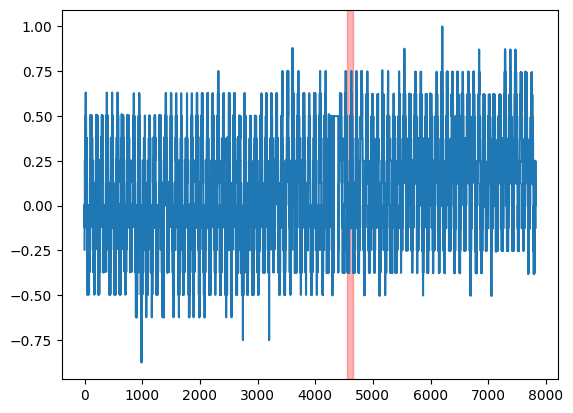

In [89]:
plotter = Plotter(new_channel)
plotter.plot_predictions(plot_real_data=True)
# plotter.plot_custom_range_predictions(4900, 7000)

### Calculate error between real and predicted data, create smoothed error

In [90]:
class ErrorWindow:
    def __init__(self, channel, e_s, window_size, window_number):
        self.channel = channel
        self.e_s = e_s
        self.window_num = window_number
        self.window_size = window_size
        self.E_seq = np.array([])
        
        self.mean = np.mean(self.e_s)
        self.std = np.std(self.e_s)
        self.epsilon = self.mean + 12 * self.std
        self.indices_anomalies = np.array([])
        self.anom_scores = []

    def find_anomalies(self):
        max_score = float('-inf')

        for z in np.arange(2, 10, 0.5):
            epsilon = self.mean + (self.std * z)
            below_epsilon = self.e_s[self.e_s < epsilon]

            delta_mean = self.mean - np.mean(below_epsilon)
            delta_std = self.std - np.std(below_epsilon)
            e_a = self.e_s[self.e_s >= epsilon]

            if len(e_a) > 0:
                anom = np.argwhere(self.e_s >= epsilon).reshape(-1)
                E_seq =[list(g) for g in mit.consecutive_groups(anom)]
                E_seq_len = len(E_seq)
                
                score = ((delta_mean/self.mean) + (delta_std/self.std)) / (E_seq_len**2 + len(e_a))
                if score > max_score:
                    max_score = score
                    self.epsilon = epsilon
                    self.E_seq = E_seq
                    # I have no idea why this is here
                    # anom = anom[anom >= len(self.e_s) - 70]
                    self.indices_anomalies = anom
                    
        return self.epsilon
    
    def score_anomalies(self, prior_idx):

        groups = [list(group) for group in mit.consecutive_groups(self.indices_anomalies)]

        for e_seq in groups:

            score_dict = {
                "start_idx": e_seq[0] + prior_idx,
                "end_idx": e_seq[-1] + prior_idx,
                "score": 0
            }

            score = max([abs(self.e_s[i] - self.epsilon)
                         / (self.mean + self.std) for i in
                         range(e_seq[0], e_seq[-1] + 1)])

            score_dict['score'] = score
            self.anom_scores.append(score_dict)

In [91]:
class Errors:
    def __init__(self, channel):
        self.channel = channel
        # self.error = np.abs(channel.y_test[:, 0] - channel.y_hat)
        self.error = [abs(y_h-y_t[0]) for y_h, y_t in
                  zip(channel.y_hat, channel.y_test)]
        self.normalized = np.mean(self.error / np.ptp(channel.y_test))
        self.e_s = pd.DataFrame(self.error).ewm(span=105).mean().values.flatten()

        self.window_size = 30
        self.batch_size = 70

        self.n_windows = int((channel.y_test.shape[0] - (self.batch_size * self.window_size)) / self.batch_size)
        self.i_anom = np.array([])
        self.anom_scores = []
        self.E_seq = []
        self.epsilons = []


    def detect_anomalies(self):

        for i in range(self.n_windows + 1):
            prior_idx = i * self.batch_size
            idx = self.window_size * self.batch_size + prior_idx
            window = ErrorWindow(self.channel, self.e_s[prior_idx:idx], self.window_size, i)
            
            self.epsilons.append(window.find_anomalies())
            window.score_anomalies(prior_idx)

            self.i_anom = np.append(self.i_anom, window.indices_anomalies + prior_idx)
            self.anom_scores = self.anom_scores + window.anom_scores


        if len(self.anom_scores) > 0:
            self.anom_scores = sorted(self.anom_scores, key=lambda x: x['score'], reverse=True)
            self.check_scores()

    def check_scores(self):
        self.anom_scores = sorted(errors.anom_scores, key=lambda x: x['start_idx'])
        for i in range(len(self.anom_scores)):
            if self.anom_scores[i]['score'] > 0.1:
                self.E_seq.append([self.anom_scores[i]['start_idx'], self.anom_scores[i]['end_idx']])

        E_seq = [self.E_seq[0]]
        for s, e in self.E_seq[1:]:
            if max(s, E_seq[-1][0]) <= min(e, E_seq[-1][1]) or s == E_seq[-1][1] + 1:
                E_seq[-1] = [min(s, E_seq[-1][0]), max(e, E_seq[-1][1])]
            else:
                E_seq.append([s, e])
        self.E_seq = E_seq
        # shift data to match the original data
        self.E_seq = [(e_seq[0] + 250,
                           e_seq[1] + 250) for e_seq in self.E_seq]

In [92]:
errors = Errors(new_channel)
errors.detect_anomalies()
max(errors.anom_scores, key=lambda x: x['score']), errors.E_seq

({'start_idx': 0, 'end_idx': 0, 'score': 1.0598741741580582},
 [(250, 250),
  (4570, 4582),
  (4631, 4684),
  (4730, 4781),
  (7660, 7703),
  (7748, 7795)])

In [93]:
# error = Errors_a(new_channel)
# error.process_batches(new_channel)
# error.E_seq

In [94]:
class Errors_a:
    def __init__(self, channel):
        self.window_size = 30
        self.batch_size = 70
        self.smoothing_perc = 0.05
        self.l_s = 250

        self.epsilons = []

        self.window_size = self.window_size
        self.n_windows = int((channel.y_test.shape[0] -
                              (self.batch_size * self.window_size))
                             / self.batch_size)
        self.i_anom = np.array([])
        self.E_seq = []
        self.anom_scores = []

        self.e = [abs(y_h-y_t[0]) for y_h, y_t in
                  zip(channel.y_hat, channel.y_test)]

        smoothing_window = int(self.batch_size * self.window_size
                               * self.smoothing_perc)

        self.e_s = pd.DataFrame(self.e).ewm(span=smoothing_window)\
            .mean().values.flatten()

        self.normalized = np.mean(self.e / np.ptp(channel.y_test))

    def process_batches(self, channel):

        for i in range(0, self.n_windows+1):
            prior_idx = i * self.batch_size
            idx = (self.window_size * self.batch_size) \
                  + (i * self.batch_size)


            window = ErrorWindow_a(channel, prior_idx, idx, self, i)

            self.epsilons.append(window.find_epsilon())

            window.compare_to_epsilon(self)

            if len(window.i_anom) == 0 and len(window.i_anom_inv) == 0:
                continue

            # window.prune_anoms()
            # window.prune_anoms(inverse=True)

            if len(window.i_anom) == 0 and len(window.i_anom_inv) == 0:
                continue

            # window.i_anom = np.sort(np.unique(
            #     np.append(window.i_anom, window.i_anom_inv))).astype('int')
            window.score_anomalies(prior_idx)

            self.i_anom = np.append(self.i_anom, window.i_anom + prior_idx)
            self.anom_scores = self.anom_scores + window.anom_scores

        if len(self.i_anom) > 0:
            groups = [list(group) for group in
                      mit.consecutive_groups(self.i_anom)]
            self.E_seq = [(int(g[0]), int(g[-1])) for g in groups
                          if not g[0] == g[-1]]

            self.E_seq = [(e_seq[0] + self.l_s,
                           e_seq[1] + self.l_s) for e_seq in self.E_seq]


class ErrorWindow_a:
    def __init__(self, channel, start_idx, end_idx, errors, window_num):

        self.i_anom = np.array([])
        self.E_seq = np.array([])
        self.non_anom_max = -1000000
        self.i_anom_inv = np.array([])
        self.E_seq_inv = np.array([])
        self.non_anom_max_inv = -1000000

        self.anom_scores = []

        self.window_num = window_num

        self.sd_lim = 12.0
        self.error_buffer = 100
        self.batch_size = 70
        self.p = 0.13
        self.sd_threshold = self.sd_lim
        self.sd_threshold_inv = self.sd_lim

        self.e_s = errors.e_s[start_idx:end_idx]

        self.mean_e_s = np.mean(self.e_s)
        self.sd_e_s = np.std(self.e_s)
        self.e_s_inv = np.array([self.mean_e_s + (self.mean_e_s - e)
                                 for e in self.e_s])

        self.epsilon = self.mean_e_s + self.sd_lim * self.sd_e_s
        self.epsilon_inv = self.mean_e_s + self.sd_lim * self.sd_e_s

        self.y_test = channel.y_test[start_idx:end_idx]
        self.sd_values = np.std(self.y_test)

        self.perc_high, self.perc_low = np.percentile(self.y_test, [95, 5])
        self.inter_range = self.perc_high - self.perc_low

        # ignore initial error values until enough history for processing
        self.l_s = 250
        self.num_to_ignore = self.l_s * 2

    def find_epsilon(self, inverse=False):
        e_s = self.e_s

        max_score = -10000000

        for z in np.arange(2, 10, 0.5):
            epsilon = self.mean_e_s + (self.sd_e_s * z)

            pruned_e_s = e_s[e_s < epsilon]

            i_anom = np.argwhere(e_s >= epsilon).reshape(-1,)

            if len(i_anom) > 0:
                # group anomalous indices into continuous sequences
                groups = [list(group) for group
                          in mit.consecutive_groups(i_anom)]
                E_seq = [(g[0], g[-1]) for g in groups if not g[0] == g[-1]]

                mean_perc_decrease = (self.mean_e_s - np.mean(pruned_e_s)) \
                                     / self.mean_e_s
                sd_perc_decrease = (self.sd_e_s - np.std(pruned_e_s)) \
                                   / self.sd_e_s
                score = (mean_perc_decrease + sd_perc_decrease) \
                        / (len(E_seq) ** 2 + len(i_anom))

                # sanity checks / guardrails
                if score >= max_score:
                    max_score = score
                    self.sd_threshold = z
                    self.epsilon = self.mean_e_s + z * self.sd_e_s

        return self.epsilon

    def compare_to_epsilon(self, errors_all, inverse=False):
        e_s = self.e_s
        epsilon = self.epsilon

        # Check: scale of errors compared to values too small?
        # if not (self.sd_e_s > (.05 * self.sd_values) or max(self.e_s)
        #         > (.05 * self.inter_range)) or not max(self.e_s) > 0.05:
        #     return

        i_anom = np.argwhere((e_s >= epsilon)).reshape(-1,)
                            #  &(e_s > 0.05 * self.inter_range)).reshape(-1,)

        if len(i_anom) == 0:
            return
        # buffer = np.arange(1, self.error_buffer+1)
        # i_anom = np.sort(np.concatenate((i_anom,
        #                                  np.array([i + buffer for i in i_anom])
        #                                  .flatten(),
        #                                  np.array([i - buffer for i in i_anom])
        #                                  .flatten())))
        # i_anom = i_anom[(i_anom < len(e_s)) & (i_anom >= 0)]

        # if it is first window, ignore initial errors (need some history)
        # if self.window_num == 0:
        #     i_anom = i_anom[i_anom >= self.num_to_ignore]
        # else:
        i_anom = i_anom[i_anom >= len(e_s) - self.batch_size]

        i_anom = np.sort(np.unique(i_anom))

        # batch_position = self.window_num * self.batch_size
        # window_indices = np.arange(0, len(e_s)) + batch_position
        # adj_i_anom = i_anom + batch_position
        # window_indices = np.setdiff1d(window_indices,
        #                               np.append(errors_all.i_anom, adj_i_anom))
        # candidate_indices = np.unique(window_indices - batch_position)
        # non_anom_max = np.max(np.take(e_s, candidate_indices))

        groups = [list(group) for group in mit.consecutive_groups(i_anom)]
        E_seq = [(g[0], g[-1]) for g in groups if not g[0] == g[-1]]

        if inverse:
            self.i_anom_inv = i_anom
            self.E_seq_inv = E_seq
            # self.non_anom_max_inv = non_anom_max
        else:
            self.i_anom = i_anom
            self.E_seq = E_seq
            # self.non_anom_max = non_anom_max

    # def prune_anoms(self, inverse=False):
    #     E_seq = self.E_seq if not inverse else self.E_seq_inv
    #     e_s = self.e_s if not inverse else self.e_s_inv
    #     non_anom_max = self.non_anom_max if not inverse \
    #         else self.non_anom_max_inv

    #     if len(E_seq) == 0:
    #         return

    #     E_seq_max = np.array([max(e_s[e[0]:e[1]+1]) for e in E_seq])
    #     E_seq_max_sorted = np.sort(E_seq_max)[::-1]
    #     E_seq_max_sorted = np.append(E_seq_max_sorted, [non_anom_max])

    #     i_to_remove = np.array([])
    #     for i in range(0, len(E_seq_max_sorted)-1):
    #         if (E_seq_max_sorted[i] - E_seq_max_sorted[i+1]) \
    #                 / E_seq_max_sorted[i] < self.p:
    #             i_to_remove = np.append(i_to_remove, np.argwhere(
    #                 E_seq_max == E_seq_max_sorted[i]))
    #         else:
    #             i_to_remove = np.array([])
    #     i_to_remove[::-1].sort()

    #     if len(i_to_remove) > 0:
    #         E_seq = np.delete(E_seq, i_to_remove, axis=0)

    #     if len(E_seq) == 0 and inverse:
    #         self.i_anom_inv = np.array([])
    #         return
    #     elif len(E_seq) == 0 and not inverse:
    #         self.i_anom = np.array([])
    #         return

    #     indices_to_keep = np.concatenate([range(e_seq[0], e_seq[-1]+1)
    #                                       for e_seq in E_seq])

    #     if not inverse:
    #         mask = np.isin(self.i_anom, indices_to_keep)
    #         self.i_anom = self.i_anom[mask]
    #     else:
    #         mask_inv = np.isin(self.i_anom_inv, indices_to_keep)
    #         self.i_anom_inv = self.i_anom_inv[mask_inv]

    def score_anomalies(self, prior_idx):
        groups = [list(group) for group in mit.consecutive_groups(self.i_anom)]

        for e_seq in groups:

            score_dict = {
                "start_idx": e_seq[0] + prior_idx,
                "end_idx": e_seq[-1] + prior_idx,
                "score": 0
            }

            score = max([abs(self.e_s[i] - self.epsilon)
                         / (self.mean_e_s + self.sd_e_s) for i in
                         range(e_seq[0], e_seq[-1] + 1)])
            inv_score = max([abs(self.e_s_inv[i] - self.epsilon_inv)
                             / (self.mean_e_s + self.sd_e_s) for i in
                             range(e_seq[0], e_seq[-1] + 1)])

            score_dict['score'] = max([score, inv_score])
            self.anom_scores.append(score_dict)

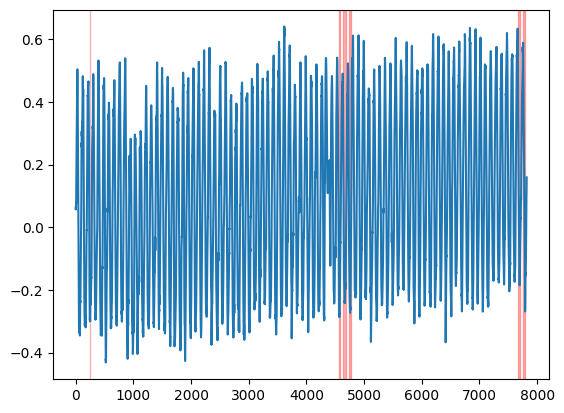

In [95]:
plotter.plot_detected_anomalies(errors.E_seq, plot_real_data=False)

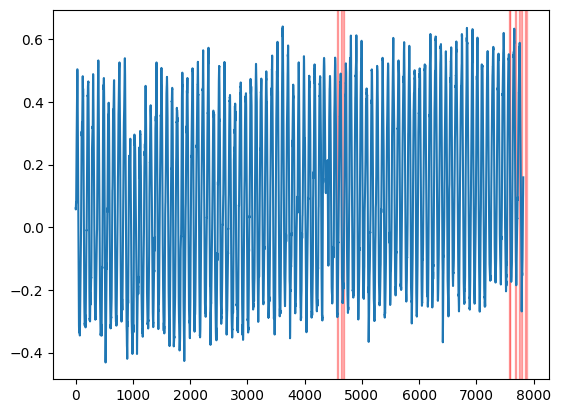

In [96]:
error = Errors_a(new_channel)
error.process_batches(new_channel)
plotter.plot_detected_anomalies(error.E_seq, plot_real_data=False)

In [97]:
class Errors_b:
    def __init__(self, channel):
        self.window_size = 30
        self.batch_size = 70
        self.smoothing_perc = 0.05
        self.l_s = 250

        self.window_size = self.window_size
        self.n_windows = int((channel.y_test.shape[0] -
                              (self.batch_size * self.window_size))
                             / self.batch_size)
        self.i_anom = np.array([])
        self.E_seq = []
        self.anom_scores = []

        # raw prediction error
        self.e = [abs(y_h-y_t[0]) for y_h, y_t in
                  zip(channel.y_hat, channel.y_test)]

        smoothing_window = int(self.batch_size * self.window_size
                               * self.smoothing_perc)
        if not len(channel.y_hat) == len(channel.y_test):
            raise ValueError('len(y_hat) != len(y_test): {}, {}'
                             .format(len(channel.y_hat), len(channel.y_test)))

        # smoothed prediction error
        self.e_s = pd.DataFrame(self.e).ewm(span=smoothing_window)\
            .mean().values.flatten()

        # for values at beginning < sequence length, just use avg
        if not channel.id == 'C-2':  # anomaly occurs early in window
            self.e_s[:self.l_s] = \
                [np.mean(self.e_s[:self.l_s * 2])] * self.l_s


        self.normalized = np.mean(self.e / np.ptp(channel.y_test))

    def adjust_window_size(self, channel):

        while self.n_windows < 0:
            self.window_size -= 1
            self.n_windows = int((channel.y_test.shape[0]
                                 - (self.batch_size * self.window_size))
                                 / self.batch_size)
            if self.window_size == 1 and self.n_windows < 0:
                raise ValueError('Batch_size ({}) larger than y_test (len={}). '
                                 'Adjust in config.yaml.'
                                 .format(self.batch_size,
                                         channel.y_test.shape[0]))

    def merge_scores(self):
        merged_scores = []
        score_end_indices = []

        for i, score in enumerate(self.anom_scores):
            if score['start_idx']-1 not in score_end_indices:
                merged_scores.append(score['score'])
                score_end_indices.append(score['end_idx'])

    def process_batches(self, channel):
        self.adjust_window_size(channel)

        for i in range(0, self.n_windows+1):
            prior_idx = i * self.batch_size
            idx = (self.window_size * self.batch_size) \
                  + (i * self.batch_size)
            if i == self.n_windows:
                idx = channel.y_test.shape[0]

            window = ErrorWindow_a(channel, prior_idx, idx, self, i)

            window.find_epsilon()
            window.find_epsilon(inverse=True)

            window.compare_to_epsilon(self)
            window.compare_to_epsilon(self, inverse=True)

            if len(window.i_anom) == 0 and len(window.i_anom_inv) == 0:
                continue

            # window.prune_anoms()
            # window.prune_anoms(inverse=True)

            if len(window.i_anom) == 0 and len(window.i_anom_inv) == 0:
                continue

            window.i_anom = np.sort(np.unique(
                np.append(window.i_anom, window.i_anom_inv))).astype('int')
            window.score_anomalies(prior_idx)

            # update indices to reflect true indices in full set of values
            self.i_anom = np.append(self.i_anom, window.i_anom + prior_idx)
            self.anom_scores = self.anom_scores + window.anom_scores

        if len(self.i_anom) > 0:
            # group anomalous indices into continuous sequences
            groups = [list(group) for group in
                      mit.consecutive_groups(self.i_anom)]
            self.E_seq = [(int(g[0]), int(g[-1])) for g in groups
                          if not g[0] == g[-1]]

            # additional shift is applied to indices so that they represent the
            # position in the original data array, obtained from the .npy files,
            # and not the position on y_test (See PR #27).
            self.E_seq = [(e_seq[0] + self.l_s,
                           e_seq[1] + self.l_s) for e_seq in self.E_seq]

            self.merge_scores()


class ErrorWindow_b:
    def __init__(self, channel, start_idx, end_idx, errors, window_num):

        self.i_anom = np.array([])
        self.E_seq = np.array([])
        self.non_anom_max = -1000000
        self.i_anom_inv = np.array([])
        self.E_seq_inv = np.array([])
        self.non_anom_max_inv = -1000000

        self.anom_scores = []

        self.window_num = window_num

        self.sd_lim = 12.0
        self.error_buffer = 100
        self.batch_size = 70
        self.p = 0.13
        self.sd_threshold = self.sd_lim
        self.sd_threshold_inv = self.sd_lim

        self.e_s = errors.e_s[start_idx:end_idx]

        self.mean_e_s = np.mean(self.e_s)
        self.sd_e_s = np.std(self.e_s)
        self.e_s_inv = np.array([self.mean_e_s + (self.mean_e_s - e)
                                 for e in self.e_s])

        self.epsilon = self.mean_e_s + self.sd_lim * self.sd_e_s
        self.epsilon_inv = self.mean_e_s + self.sd_lim * self.sd_e_s

        self.y_test = channel.y_test[start_idx:end_idx]
        self.sd_values = np.std(self.y_test)

        self.perc_high, self.perc_low = np.percentile(self.y_test, [95, 5])
        self.inter_range = self.perc_high - self.perc_low

        # ignore initial error values until enough history for processing
        self.l_s = 250
        self.num_to_ignore = self.l_s * 2
        # if y_test is small, ignore fewer
        if len(channel.y_test) < 2500:
            self.num_to_ignore = self.l_s
        if len(channel.y_test) < 1800:
            self.num_to_ignore = 0

    def find_epsilon(self, inverse=False):
        e_s = self.e_s if not inverse else self.e_s_inv

        max_score = -10000000

        for z in np.arange(2.5, self.sd_lim, 0.5):
            epsilon = self.mean_e_s + (self.sd_e_s * z)

            pruned_e_s = e_s[e_s < epsilon]

            i_anom = np.argwhere(e_s >= epsilon).reshape(-1,)
            buffer = np.arange(1, self.error_buffer)
            i_anom = np.sort(np.concatenate((i_anom,
                                            np.array([i+buffer for i in i_anom])
                                             .flatten(),
                                            np.array([i-buffer for i in i_anom])
                                             .flatten())))
            i_anom = i_anom[(i_anom < len(e_s)) & (i_anom >= 0)]
            i_anom = np.sort(np.unique(i_anom))

            if len(i_anom) > 0:
                # group anomalous indices into continuous sequences
                groups = [list(group) for group
                          in mit.consecutive_groups(i_anom)]
                E_seq = [(g[0], g[-1]) for g in groups if not g[0] == g[-1]]

                mean_perc_decrease = (self.mean_e_s - np.mean(pruned_e_s)) \
                                     / self.mean_e_s
                sd_perc_decrease = (self.sd_e_s - np.std(pruned_e_s)) \
                                   / self.sd_e_s
                score = (mean_perc_decrease + sd_perc_decrease) \
                        / (len(E_seq) ** 2 + len(i_anom))

                # sanity checks / guardrails
                if score >= max_score and len(E_seq) <= 5 and \
                        len(i_anom) < (len(e_s) * 0.5):
                    max_score = score
                    if not inverse:
                        self.sd_threshold = z
                        self.epsilon = self.mean_e_s + z * self.sd_e_s
                    else:
                        self.sd_threshold_inv = z
                        self.epsilon_inv = self.mean_e_s + z * self.sd_e_s

    def compare_to_epsilon(self, errors_all, inverse=False):
        e_s = self.e_s if not inverse else self.e_s_inv
        epsilon = self.epsilon if not inverse else self.epsilon_inv

        # Check: scale of errors compared to values too small?
        if not (self.sd_e_s > (.05 * self.sd_values) or max(self.e_s)
                > (.05 * self.inter_range)) or not max(self.e_s) > 0.05:
            return

        i_anom = np.argwhere((e_s >= epsilon) &
                             (e_s > 0.05 * self.inter_range)).reshape(-1,)

        if len(i_anom) == 0:
            return
        buffer = np.arange(1, self.error_buffer+1)
        i_anom = np.sort(np.concatenate((i_anom,
                                         np.array([i + buffer for i in i_anom])
                                         .flatten(),
                                         np.array([i - buffer for i in i_anom])
                                         .flatten())))
        i_anom = i_anom[(i_anom < len(e_s)) & (i_anom >= 0)]

        # if it is first window, ignore initial errors (need some history)
        if self.window_num == 0:
            i_anom = i_anom[i_anom >= self.num_to_ignore]
        else:
            i_anom = i_anom[i_anom >= len(e_s) - self.batch_size]

        i_anom = np.sort(np.unique(i_anom))

        # capture max of non-anomalous values below the threshold
        # (used in filtering process)
        batch_position = self.window_num * self.batch_size
        window_indices = np.arange(0, len(e_s)) + batch_position
        adj_i_anom = i_anom + batch_position
        window_indices = np.setdiff1d(window_indices,
                                      np.append(errors_all.i_anom, adj_i_anom))
        candidate_indices = np.unique(window_indices - batch_position)
        non_anom_max = np.max(np.take(e_s, candidate_indices))

        # group anomalous indices into continuous sequences
        groups = [list(group) for group in mit.consecutive_groups(i_anom)]
        E_seq = [(g[0], g[-1]) for g in groups if not g[0] == g[-1]]

        if inverse:
            self.i_anom_inv = i_anom
            self.E_seq_inv = E_seq
            self.non_anom_max_inv = non_anom_max
        else:
            self.i_anom = i_anom
            self.E_seq = E_seq
            self.non_anom_max = non_anom_max

    def prune_anoms(self, inverse=False):
        E_seq = self.E_seq if not inverse else self.E_seq_inv
        e_s = self.e_s if not inverse else self.e_s_inv
        non_anom_max = self.non_anom_max if not inverse \
            else self.non_anom_max_inv

        if len(E_seq) == 0:
            return

        E_seq_max = np.array([max(e_s[e[0]:e[1]+1]) for e in E_seq])
        E_seq_max_sorted = np.sort(E_seq_max)[::-1]
        E_seq_max_sorted = np.append(E_seq_max_sorted, [non_anom_max])

        i_to_remove = np.array([])
        for i in range(0, len(E_seq_max_sorted)-1):
            if (E_seq_max_sorted[i] - E_seq_max_sorted[i+1]) \
                    / E_seq_max_sorted[i] < self.p:
                i_to_remove = np.append(i_to_remove, np.argwhere(
                    E_seq_max == E_seq_max_sorted[i]))
            else:
                i_to_remove = np.array([])
        i_to_remove[::-1].sort()

        if len(i_to_remove) > 0:
            E_seq = np.delete(E_seq, i_to_remove, axis=0)

        if len(E_seq) == 0 and inverse:
            self.i_anom_inv = np.array([])
            return
        elif len(E_seq) == 0 and not inverse:
            self.i_anom = np.array([])
            return

        indices_to_keep = np.concatenate([range(e_seq[0], e_seq[-1]+1)
                                          for e_seq in E_seq])

        if not inverse:
            mask = np.isin(self.i_anom, indices_to_keep)
            self.i_anom = self.i_anom[mask]
        else:
            mask_inv = np.isin(self.i_anom_inv, indices_to_keep)
            self.i_anom_inv = self.i_anom_inv[mask_inv]

    def score_anomalies(self, prior_idx):
        groups = [list(group) for group in mit.consecutive_groups(self.i_anom)]

        for e_seq in groups:

            score_dict = {
                "start_idx": e_seq[0] + prior_idx,
                "end_idx": e_seq[-1] + prior_idx,
                "score": 0
            }

            score = max([abs(self.e_s[i] - self.epsilon)
                         / (self.mean_e_s + self.sd_e_s) for i in
                         range(e_seq[0], e_seq[-1] + 1)])
            inv_score = max([abs(self.e_s_inv[i] - self.epsilon_inv)
                             / (self.mean_e_s + self.sd_e_s) for i in
                             range(e_seq[0], e_seq[-1] + 1)])

            # the max score indicates whether anomaly was from regular
            # or inverted errors
            score_dict['score'] = max([score, inv_score])
            self.anom_scores.append(score_dict)

In [98]:
error_b = Errors_b(new_channel)
error_b.process_batches(new_channel)

In [99]:
error_b.E_seq

[(4570, 4582),
 (4639, 4684),
 (7572, 7583),
 (7585, 7586),
 (7667, 7701),
 (7748, 7795),
 (7841, 7867),
 (7878, 7879)]

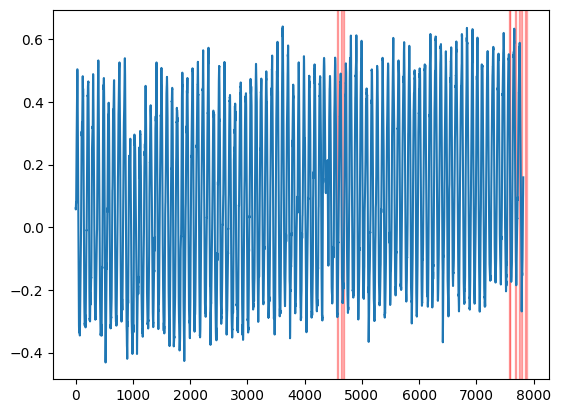

In [100]:
plotter.plot_detected_anomalies(error_b.E_seq, plot_real_data=False)